# Chirp Radar

Consider a simple chirp radar looking at an object $d$ meters away. Assuming the radar's transmitting and receiving antennas are in the same place, the receiver will receive the transmitted signal with a $\tau = \frac{2d}{c}$ second delay and some noise and attenuation. Plugging in the transmitted waveform and ignoring noise and attenuation for now, we have

$$TX(t) = A e^{j \omega(t) t} = A e^{j (mt + b) t}$$

$$RX(t) = TX(t - \tau) =  A e^{j (m(t-\tau) + b) (t-\tau)}$$

Given $TX(t)$ and $RX(t)$, we want to find $\tau$.

$$TX(t) = A e^{jbt} e^{jmt^2}$$

$$RX(t) = A e^{j (m(t-\tau) + b) (t-\tau)} = A e^{jbt} e^{-jb\tau} e^{j (m(t-\tau)) (t-\tau)} = A e^{jbt} e^{-jb\tau} e^{j m (t^2 - 2 \tau t + \tau^2)} = A e^{jbt} e^{jmt^2} e^{j(m \tau - b)\tau} e^{-j2m\tau t} $$

Now we see that $TX(t)$ and $RX(t)$ have common $e^{jbt}$ and $e^{jmt^2}$ terms, which we can cancel by multiplying $TX(t)$ by the conjugate of $RX(t)$


$$ TX(t) \cdot RX^*(t) = \|A\|^2 e^{j(b - m \tau)\tau} e^{j(2m\tau)t} $$

While $\tau$ is still not know, we know that $\|A\|^2 e^{j(b - m \tau)\tau}$ will remain a constant over all $t$, so our expression for $TX(t) RX^*(t)$ is actually a pure sinusoid with unknown amplitude and frequency

$$TX(t) \cdot RX^*(t) = A_1 e^{j \omega_1 t}$$

$$ A_1 = \|A\|^2 e^{j(b - m \tau)\tau} $$

$$ \omega_1 = 2m\tau $$

We can find the frequency of this sinusoid, and thus $\tau$ and $d$, using the FFT. We'll do an simulation of a radar looking at a target that's 100 km away, and we'll see if we can recover that distance using this algorithm.

In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib

fs = 20e6  # sampling rate
N = 1e5  # number of samples

m = 300  # chirp slope
b = 1  # chirp initial (angular) frequency

t = np.arange(N) / float(fs)
w = m * t + b
tx = np.cos(w * fs * t)
tx[int(len(tx) / 2) :] = 0

d = 100e3  # m
c = 3e8  # m/s

delay_s = 2 * d / c
delay_samps = int(delay_s * fs)

rx = np.roll(tx, delay_samps)

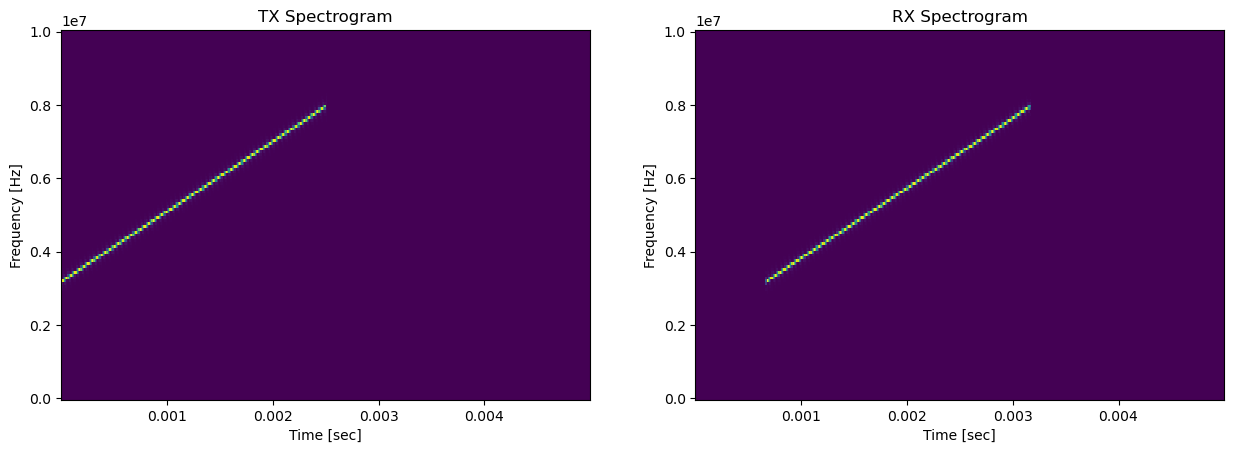

In [4]:
s_f, s_t, S_tx = signal.spectrogram(tx, fs)
s_f, s_t, S_rx = signal.spectrogram(rx, fs)

plt.figure().set_figwidth(15)

plt.subplot(1, 2, 1)
plt.pcolormesh(s_t, s_f, S_tx)
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [sec]")
plt.title("TX Spectrogram")

plt.subplot(1, 2, 2)
plt.pcolormesh(s_t, s_f, S_rx)
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [sec]")
plt.title("RX Spectrogram")

plt.show()

In [5]:
z = tx * np.conj(rx)

freq = np.fft.fftfreq(z.shape[-1])
omega = 2 * np.pi * freq
win = np.hanning(len(z))
Z = np.fft.fft(win * z)

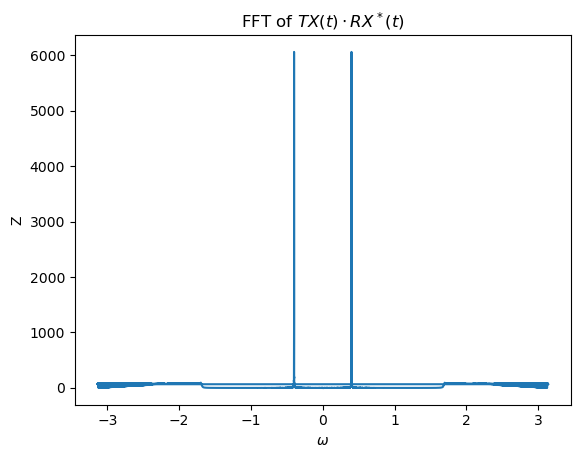

In [6]:
plt.plot(omega, np.abs(Z))
plt.xlabel("$\omega$")
plt.ylabel("Z")
plt.title("FFT of $TX(t) \cdot RX^*(t)$")
plt.show()

Getting the peak frequency and the corresponding distance,

In [7]:
w_1 = omega[np.argmax(np.abs(Z))]
tau_est = w_1 / (2 * m)
d_est = c * tau_est / 2

d_est

99996.89416376314

# Exercises

1. Re-write this entire simulation on your own, without referencing this notebook. If you're struggling, reference the previous notebooks, but do your best without looking at this one.

2. Would this method work with a quadratic chirp?
  - Explain why you think it does or doesn't work before moving on to the next step.
  - Simulate it, re-using your code from the previous notebook's exercise.
  - Bonus (hard):
    - If it works, use the simulation parameters and results to explain why linear chirps are prefered to quadratic chirps.
    - If it doesn't, transform `tx * np.conj(rx)` so that it can still be used to estimate `delay_s`

Pretty close to 100 km!